In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
def load_training_dataset():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
    )

    trainset = torchvision.datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=len(trainset), shuffle=True, num_workers=2
    )

    testset = torchvision.datasets.MNIST(
        root="data", train=False, download=True, transform=transform
    )

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2
    )

    dataset_training_images, dataset_training_labels = next(iter(trainloader))

    return dataset_training_images, dataset_training_labels


dataset_training_images, dataset_training_labels = load_training_dataset()

print(dataset_training_images.size())
print(dataset_training_labels.size())


6.0%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




23.8%

100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



torch.Size([60000, 1, 28, 28])
torch.Size([60000])


In [3]:
class MNISTAutoEncoder(torch.nn.Module):
    def __init__(self, feature_space_dimensionality):
        super().__init__()

        self.linear_encoder_1 = torch.nn.Linear(in_features=1 * 28 * 28, out_features=64)
        self.linear_encoder_2 = torch.nn.Linear(in_features=64, out_features=64)
        self.linear_encoder_final = torch.nn.Linear(in_features=64, out_features=feature_space_dimensionality)

        self.linear_decoder_1 = torch.nn.Linear(in_features=feature_space_dimensionality, out_features=64)
        self.linear_decoder_2 = torch.nn.Linear(in_features=64, out_features=64)
        self.linear_decoder_final = torch.nn.Linear(in_features=64, out_features=1 * 28 * 28)      


    def forward(self, tensor_images):
        x = tensor_images.view(-1, 1 * 28 * 28)

        x = self.linear_encoder_1(x)
        x = torch.relu(x)

        x = self.linear_encoder_2(x)
        x = torch.relu(x)

        encoding = self.linear_encoder_final(x)

        x = self.linear_decoder_1(encoding)
        x = torch.relu(x)

        x = self.linear_decoder_2(x)
        x = torch.relu(x)

        return self.linear_decoder_final(x).view(-1, 1, 28, 28)

    def get_encoding(self, tensor_images):
        x = tensor_images.view(-1, 1 * 28 * 28)

        x = self.linear_encoder_1(x)
        x = torch.relu(x)
        
        x = self.linear_encoder_2(x)
        x = torch.relu(x)

        return self.linear_encoder_final(x)


In [4]:
mnist_auto_encoder = MNISTAutoEncoder(feature_space_dimensionality=10)
print(mnist_auto_encoder)

MNISTAutoEncoder(
  (linear_encoder_1): Linear(in_features=784, out_features=64, bias=True)
  (linear_encoder_2): Linear(in_features=64, out_features=64, bias=True)
  (linear_encoder_final): Linear(in_features=64, out_features=10, bias=True)
  (linear_decoder_1): Linear(in_features=10, out_features=64, bias=True)
  (linear_decoder_2): Linear(in_features=64, out_features=64, bias=True)
  (linear_decoder_final): Linear(in_features=64, out_features=784, bias=True)
)


In [6]:
loss = torch.nn.MSELoss()
optimiser = torch.optim.Adam(mnist_auto_encoder.parameters())

In [9]:
def divide_in_batches_32(tensor_dataset):
    number_samples = tensor_dataset.size()[0]

    step = 32

    list_batches_dataset = []
    for index in range(0, number_samples, step):
        new_batch = tensor_dataset[index : index + step]
        list_batches_dataset.append(new_batch)

    return list_batches_dataset

list_batches_images = divide_in_batches_32(dataset_training_images)
list_batch_labels = divide_in_batches_32(dataset_training_labels)


In [8]:
def train_autoencoder_batches(mnist_autoencoder, loss, optimiser, list_batches_images, number_training_steps):
    for _ in range(number_training_steps):

        running_loss = 0.0

        for batch_image in list_batches_images:
            optimiser.zero_grad()

            # Compute Loss
            reconstruction = mnist_autoencoder(batch_image)
            value_loss = loss.forward(input=reconstruction,
                                      target=batch_image)

            value_loss.backward()
            optimiser.step()

            running_loss += value_loss.item()

        running_loss = running_loss / len(list_batches_images)
        print("running loss:", running_loss)

In [11]:
loss = torch.nn.MSELoss()
optimiser = torch.optim.Adam(mnist_auto_encoder.parameters())
train_autoencoder_batches(
    mnist_auto_encoder, loss, optimiser, list_batches_images, number_training_steps=5
)


running loss: 0.16435374573866526
running loss: 0.1205908857067426
running loss: 0.11262955747842789
running loss: 0.10782137358188629
running loss: 0.10454479095538458


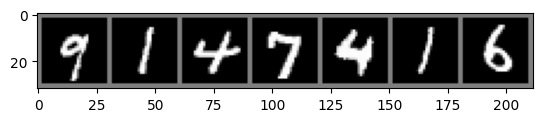

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


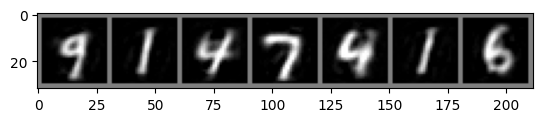

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

with torch.no_grad():
    images = dataset_training_images[0:7]

    imshow(torchvision.utils.make_grid(images))

    reconstructions = mnist_auto_encoder(images)
    imshow(torchvision.utils.make_grid(reconstructions))